#  XPCS   Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [2]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [3]:
#hdr = db[{{ uid }}]

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### Lazy Eiger Handler (later will goto databroker)

In [5]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

In [6]:
import skxray.core.roi as roi

In [7]:
%matplotlib notebook
#%matplotlib inline

### Get the events from the uid

In [8]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("%s: %s" % (key, val))

In [133]:
uid = 'c423e856'

uid = '528bd8'
uid = '54614d43'
#uid = '95782687'
#uid= 'fa5fdae'
#uid = 'ff9f20c0'

hdr = db[uid]

In [136]:
ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'], fill = True)

hdf5 path = /XF11ID/data/2015/11/6/b7efbf1f-8199-499d-8f0c_538_master.h5


In [137]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2015/11/6/'

In [138]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 2000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


In [139]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 1830.0,
 'count_time': 1.0,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'framerate': 0.99998998651994853,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


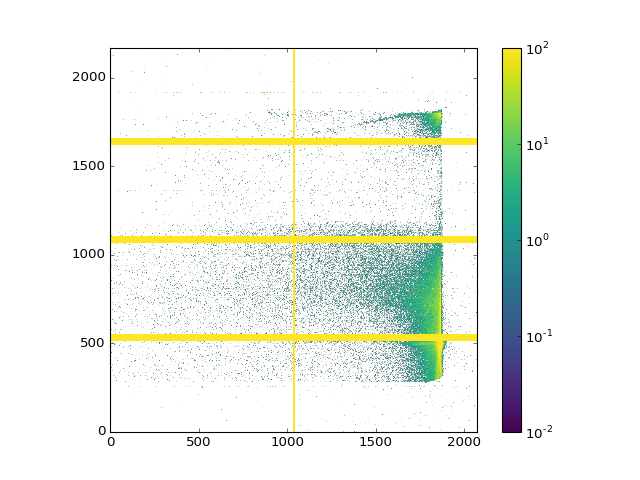

In [146]:
fig, ax = plt.subplots()
im=ax.imshow(imgs[0], origin='lower' ,cmap='viridis',
             norm= LogNorm(vmin=0.01, vmax=100.0 ) )
fig.colorbar(im)
plt.show()

## load a mask if exist 
### otherwise create a mask using Mask pipeline

In [147]:
#mask = np.load(uid+"_mask.npy")
#mask = np.load( path +  str(uid)+"_mask.npy"))
#mask = imgs.md['pixel_mask'][::-1,:]

mask = np.load( path +  str(uid)+"_mask.npy")
 

## Plot the mask

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


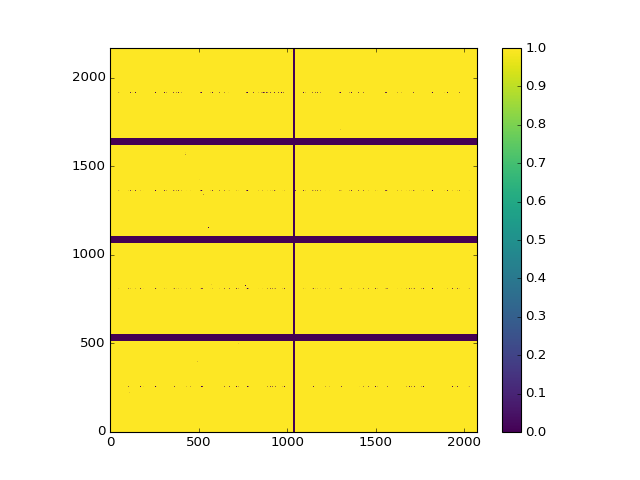

In [148]:
fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

In [24]:
class Reverse_Coordinate(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        img =self.indexable[key] * mask
        return img[::-1,:]
imgsr = Reverse_Coordinate(imgs, mask)    

In [25]:
imgsr[100].max()

119657

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

<IPython.core.display.Javascript object>


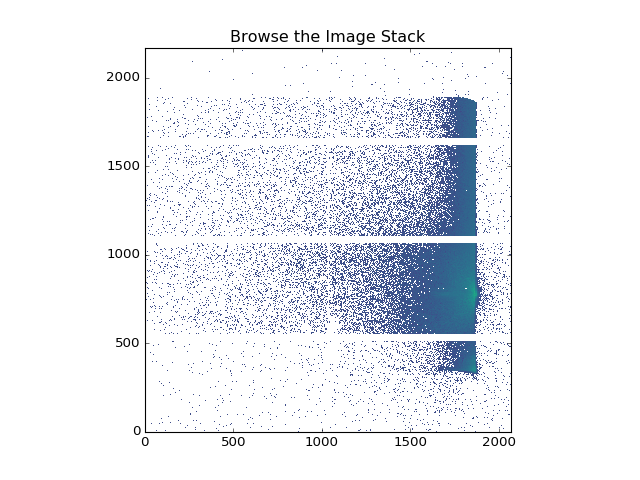

In [26]:
from ipywidgets import interact

def view_image(i):
    fig, ax = plt.subplots()
    ax.imshow(imgsr[i], interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e10 ) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, Nimg-1))

### hey, let's see if any images are bad!

In [27]:
bin_img = 25
imgsum = [np.sum(img *mask) for img in imgsr[::bin_img ]]

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


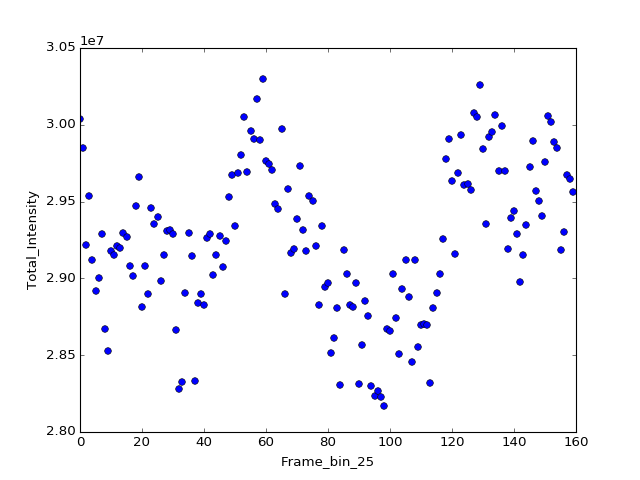

In [85]:
fig, ax = plt.subplots()  
ax.plot(imgsum,'bo')
ax.set_xlabel( 'Frame_bin_%s'%bin_img )
ax.set_ylabel( 'Total_Intensity' )
plt.show()

### Get the Averaged Image Data

In [29]:
def average_img( imgs, Ns=None,Ne = None ):
    ''' Do imgs average,
        Optiions:
        imgs: the image seriers
        Ns: the start image
        Ne: the last image
        e.g.,
        ave = average_img(imgs)'''
    import numpy as np 
    ave = np.zeros_like(imgs[0],dtype =float)
    #if Ns is None:Ns=0
    #if Ne is None:Ne=len(imgs)
    #if Ne>len(imgs):Ne=len(imgs)
    for i in range(Ns,Ne):
        ave += imgs[i]
    ave /= (Ne-Ns)
    return ave


In [86]:
avg_img = np.average(imgsr[::100], axis=0)

In [87]:
avg_img = average_img( imgsr,0,2000 )

## Plot the averged image with the mask

In [32]:
print (avg_img.max())

2164464.1945


/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


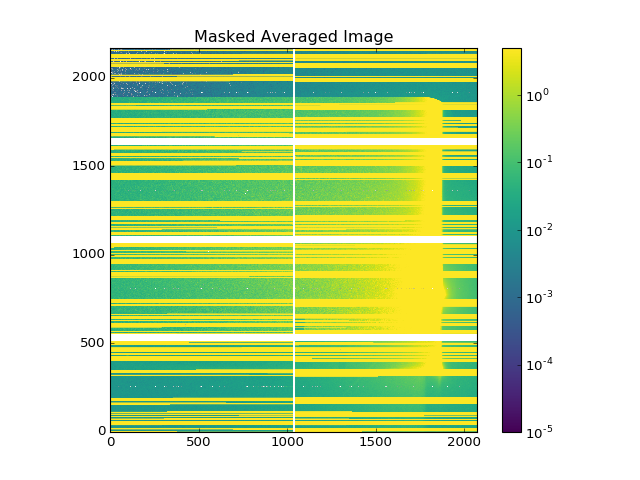

In [88]:
#img_mask = avg_img 

fig, ax = plt.subplots()
im = ax.imshow(avg_img, cmap='viridis', origin = 'lower',  norm= LogNorm( vmin=0.00001, vmax=.5e1 ) )
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [34]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 1830.0,
 'count_time': 1.0,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'framerate': 0.99998998651994853,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [35]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4810        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [36]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi

import skxray.core.correlation as corr
import skxray.core.utils as utils

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Get the approximate center and see the statistic to make sure 

In [37]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(840.0, 1830.0)

In [38]:
#center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])
center = [840, 1830]  # center of the speckle pattern
center=[center[1], center[0]]

center

[1830, 840]

### Qz, Qr Average : to do!

# GiSAXS get q-map (qz and qr)

In [39]:
def make_gisaxs_grid( qr_w= 10, qz_w = 12, dim_r =100,dim_z=120):
    y, x = np.indices( [dim_z,dim_r] )
    Nr = int(dim_r/qp_w)
    Nz = int(dim_z/qz_w)
    noqs = Nr*Nz
    
    ind = 1
    for i in range(0,Nr):
        for j in range(0,Nz):        
            y[ qr_w*i: qr_w*(i+1), qz_w*j:qz_w*(j+1)]=  ind
            ind += 1 
    return y 

In [40]:
def get_incident_angles( inc_x0, inc_y0, refl_x0, refl_y0, pixelsize=[75,75], Lsd=5.0):
    ''' giving: incident beam center: bcenx,bceny
                reflected beam on detector: rcenx, rceny
                sample to detector distance: Lsd, in meters
                pixelsize: 75 um for Eiger4M detector
        get incident_angle (alphai), the title angle (phi)
    '''
    px,py = pixelsize
    phi = np.arctan2( (refl_x0 - inc_x0)*px *10**(-6), (refl_y0 - inc_y0)*py *10**(-6) )    
    alphai = np.arctan2( (refl_y0 -inc_y0)*py *10**(-6),  Lsd ) /2.     
    #thetai = np.arctan2(  (rcenx - bcenx)*px *10**(-6), Lsd   ) /2.  #??   
    
    return alphai,phi 
    
    

In [41]:
def get_reflected_angles(inc_x0, inc_y0, refl_x0, refl_y0, thetai=0.0,
                         pixelsize=[75,75], Lsd=5.0,dimx = 2070.,dimy=2167.):
    
    ''' giving: incident beam center: bcenx,bceny
                reflected beam on detector: rcenx, rceny
                sample to detector distance: Lsd, in meters                
                pixelsize: 75 um for Eiger4M detector
                detector image size: dimx = 2070,dimy=2167 for Eiger4M detector
        get  reflected angle alphaf (outplane)
             reflected angle thetaf (inplane )
    '''    
    
    alphai, phi =  get_incident_angles( inc_x0, inc_y0, refl_x0, refl_y0, pixelsize, Lsd)
    print ('The incident_angle (alphai) is: %s'%(alphai* 180/np.pi))
    px,py = pixelsize
    y, x = np.indices( [dimy,dimx] )    
    alphaf = np.arctan2( (y-inc_y0)*py*10**(-6), Lsd )/2 - alphai 
    thetaf = np.arctan2( (x-inc_x0)*px*10**(-6), Lsd )/2 - thetai   
    
    return alphaf,thetaf, alphai, phi

In [42]:
def convert_gisaxs_pixel_to_q( inc_x0, inc_y0, refl_x0, refl_y0, 
                               pixelsize=[75,75], Lsd=5.0,dimx = 2070.,dimy=2167.,
                              thetai=0.0, lamda=1.0 ):
    
    ''' giving: incident beam center: bcenx,bceny
                reflected beam on detector: rcenx, rceny
                sample to detector distance: Lsd, in meters                
                pixelsize: 75 um for Eiger4M detector
                detector image size: dimx = 2070,dimy=2167 for Eiger4M detector                
                wavelength: angstron               
                
        get: q_parallel (qp), q_direction_z (qz)
                
    '''         
    
    
    alphaf,thetaf,alphai, phi = get_reflected_angles( inc_x0, inc_y0, refl_x0, refl_y0, thetai, pixelsize, Lsd,dimx,dimy)
       
    pref = 2*np.pi/lamda
    
    qx = np.cos( alphaf)*np.cos( 2*thetaf) - np.cos( alphai )*np.cos( 2*thetai)  
    qy_ = np.cos( alphaf)*np.sin( 2*thetaf) - np.cos( alphai )*np.sin ( 2*thetai)    
    qz_ = np.sin(alphaf) + np.sin(alphai)   
    
    qy = qz_* np.sin( phi) + qy_*np.cos(phi) 
    qz = qz_* np.cos( phi) - qy_*np.sin(phi)   
    
    qr = np.sqrt( qx**2 + qy**2 ) 
    
    
    return qx*pref  , qy*pref  , qr*pref  , qz*pref  
    

In [43]:
inc_x0 = 1890
inc_y0 = 340
refl_x0 = 1890
refl_y0 = 1670
Lsd= 4.81
lamda= 12.4/9

In [44]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Lsd )

The incident_angle (alphai) is: 0.59401610235


In [45]:
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lamda, Lsd=Lsd )

The incident_angle (alphai) is: 0.59401610235


/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


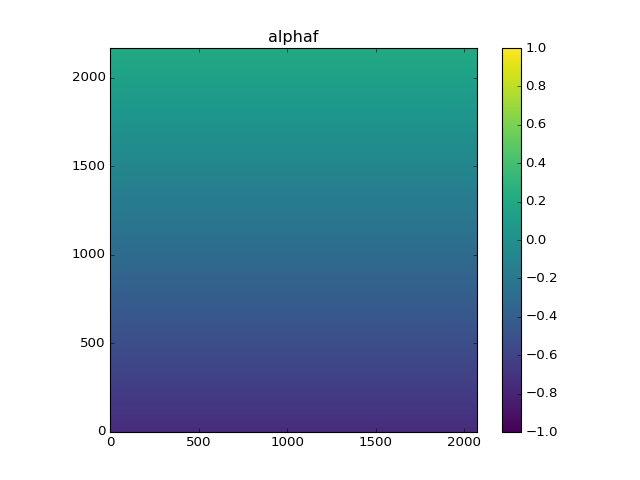

In [89]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(alphaf*180/np.pi, origin='lower' ,cmap='viridis',vmin=-1,vmax= 1 )
fig.colorbar(im)
ax.set_title( 'alphaf')
plt.show()

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


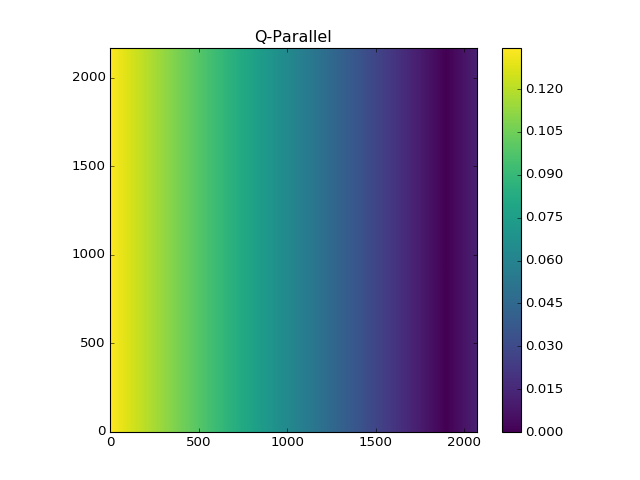

In [90]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(qr, origin='lower' ,cmap='viridis',vmin=qr.min(),vmax= qr.max() )
fig.colorbar(im)
ax.set_title( 'Q-Parallel')
plt.show()

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


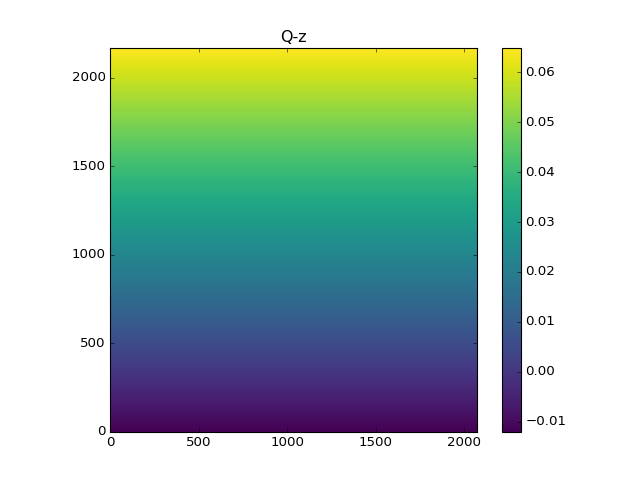

In [91]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(qz, origin='lower' ,cmap='viridis',vmin=qz.min(),vmax= qz.max() )
fig.colorbar(im)
ax.set_title( 'Q-z')
plt.show()

# get GiSAXS label array

In [92]:
def get_qedge( qstart,qend,qwidth,noqs,  ):
    ''' DOCUMENT make_qlist( )
    give qstart,qend,qwidth,noqs
    return a qedge by giving the noqs, qstart,qend,qwidth.
           a qcenter, which is center of each qedge 
    KEYWORD:  None    ''' 
    import numpy as np 
    qcenter = np.linspace(qstart,qend,noqs)
    print ('the qcenter is:  %s'%qcenter )
    qedge=np.zeros(2*noqs) 
    qedge[::2]= (  qcenter- (qwidth/2)  ) #+1  #render  even value
    qedge[1::2]= ( qcenter+ qwidth/2) #render odd value
    return qedge, qcenter

In [93]:
def get_qmap_label( qmap, qedge ):
    import numpy as np
    '''give a qmap and qedge to bin the qmap into a label array'''
    edges = np.atleast_2d(np.asarray(qedge)).ravel()
    label_array = np.digitize(qmap.ravel(), edges, right=False)
    label_array = np.int_(label_array)
    label_array = (np.where(label_array % 2 != 0, label_array, 0) + 1) // 2
    label_array = label_array.reshape( qmap.shape )
    return label_array
    

In [94]:
def get_qzrmap(label_array_qz, label_array_qr, qz_center, qr_center   ):
    qzmax = label_array_qz.max()
    label_array_qr_ = np.zeros( label_array_qr.shape  )
    ind = np.where(label_array_qr!=0)
    label_array_qr_[ind ] =  label_array_qr[ ind ] + 1E4  #add some large number to qr
    label_array_qzr = label_array_qz * label_array_qr_  
    
    #convert label_array_qzr to [1,2,3,...]
    uqzr = np.unique( label_array_qzr )[1:]
    
    uqz = np.unique( label_array_qz )[1:]
    uqr = np.unique( label_array_qr )[1:]
    #print (uqzr)
    label_array_qzr_ = np.zeros_like( label_array_qzr )
    newl = np.arange( 1, len(uqzr)+1)
    
    qzc =list(qz_center) * len( uqr )
    qrc= [  [qr_center[i]]*len( uqz ) for i in range(len( uqr ))  ]
    
    for i, label in enumerate(uqzr):
        #print (i, label)
        label_array_qzr_.ravel()[ np.where(  label_array_qzr.ravel() == label)[0] ] = newl[i]    
    
    
    return np.int_(label_array_qzr_), np.array( qzc ), np.concatenate(np.array(qrc ))
    
    

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


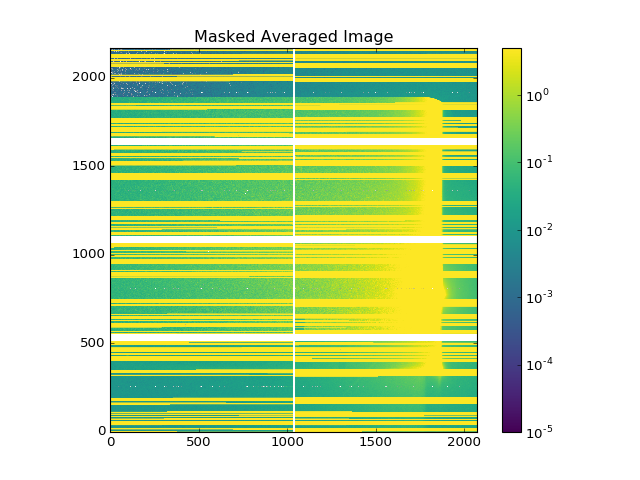

In [95]:
fig, ax = plt.subplots()
im = ax.imshow(avg_img, cmap='viridis', origin = 'lower',  norm= LogNorm( vmin=0.00001, vmax=.5e1 ) )
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

In [132]:
np.random.randint?

# Get q||-intensity

In [96]:
def get_qr_intensity( qr, data,vert_rect, show_roi=True ):
    V_K_label_array = roi.rectangles(vert_rect, data.shape)  #(y,x, hight, wdith)
    qr_ = qr  *V_K_label_array
    data_ = data*V_K_label_array    
    if show_roi:
        fig, ax = plt.subplots()
        im = plt.imshow(data_,origin='lower',norm= LogNorm( vmin=.1, vmax=1e0 ) )
        fig.colorbar(im)
        plt.show()
    
    data_ave = np.average( data, axis=0)
    qr_ave = np.average( qr_, axis=0)
    
    fig, ax = plt.subplots()
    ax.plot( qr_ave, data_ave, 'bo')
    
    
    
    

In [97]:
vert_rect = ( ( 1163, 10, 1541-1163, 1568-10) , ) 

<IPython.core.display.Javascript object>


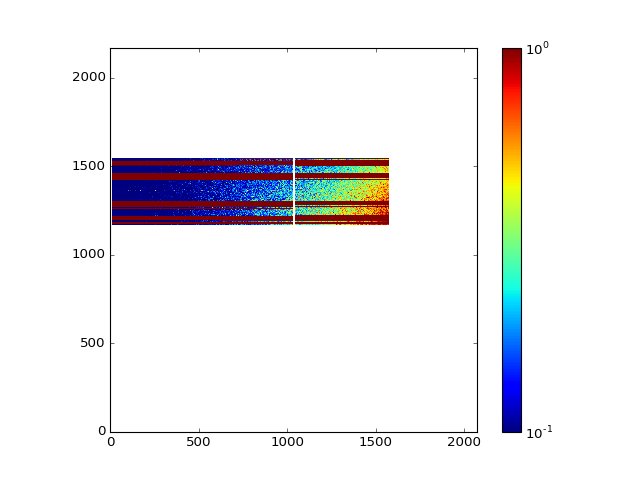

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


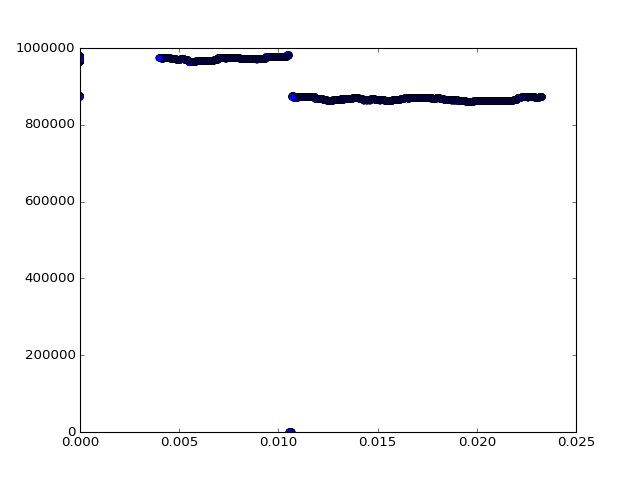

In [98]:
get_qr_intensity( qr, avg_img, vert_rect)

In [56]:
#roi.rectangles?

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


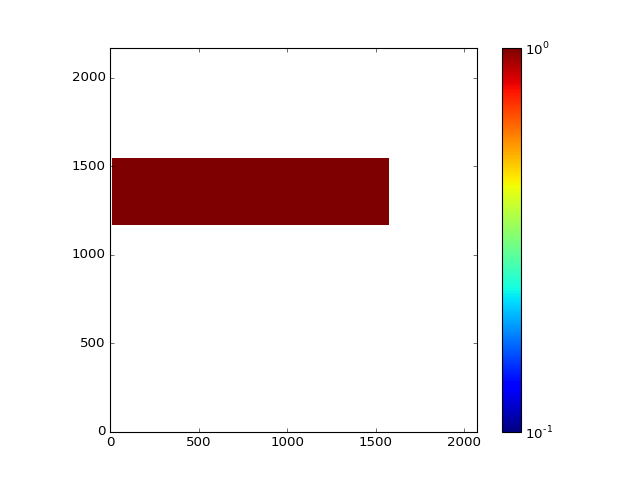

In [99]:
#vert_rect = ( (800, 803,800, 40), (1554, 546, 30, 40), (1454, 1098, 20, 60)) 

V_K_label_array = roi.rectangles(vert_rect, avg_img.shape)  #(y,x, hight, wdith)
fig, ax = plt.subplots()
im = plt.imshow(V_K_label_array, origin='lower',norm= LogNorm( vmin=.1, vmax=1e0 ) )
fig.colorbar(im)
plt.show()


In [100]:
np.unique(V_K_label_array)

array([0, 1])

In [101]:
qr_ = qr  *V_K_label_array

In [102]:
data = avg_img*V_K_label_array

In [103]:
data_ave = np.average( data, axis=0)
qr_ave = np.average( qr_, axis=0)

In [104]:
avg_img.max()

2164464.1945000002

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


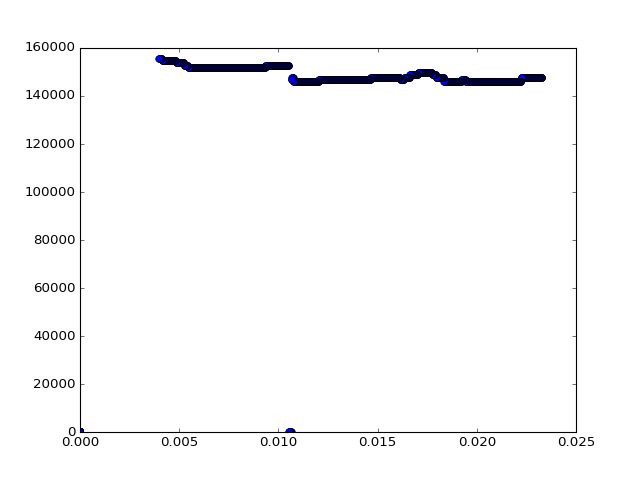

In [105]:
plt.figure()
plt.plot( qr_ave, data_ave, 'bo')
plt.show()

In [106]:
data_ave.shape

(2070,)

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


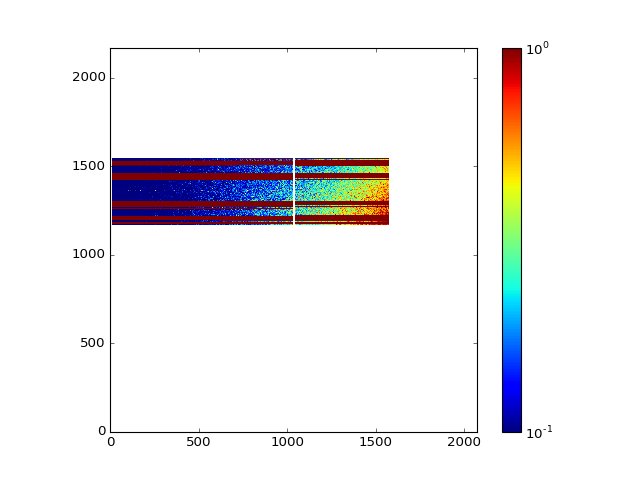

In [107]:
fig, ax = plt.subplots()
im = plt.imshow(data,origin='lower',norm= LogNorm( vmin=.1, vmax=1e0 ) )
fig.colorbar(im)
plt.show()


In [108]:
qr_edge, qr_center = get_qedge(0.05 ,0.14, (-0.05+0.14)/(15+0), 15 )

the qcenter is:  [ 0.05        0.05642857  0.06285714  0.06928571  0.07571429  0.08214286
  0.08857143  0.095       0.10142857  0.10785714  0.11428571  0.12071429
  0.12714286  0.13357143  0.14      ]


In [109]:
qz_edge, qz_center = get_qedge( 0.029,0.044,  (0.044 - 0.029)/3, 3 )

the qcenter is:  [ 0.029   0.0365  0.044 ]


In [110]:
label_array_qz = get_qmap_label( qz, qz_edge)
label_array_qr = get_qmap_label( qr, qr_edge)
label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )

In [111]:
labels_qzr, indices_qzr = roi.extract_label_indices( label_array_qzr  )
labels_qz, indices_qz = roi.extract_label_indices( label_array_qz  )
labels_qr, indices_qr = roi.extract_label_indices( label_array_qr  )

In [112]:
num_qz = len(np.unique( labels_qz ))
num_qr = len(np.unique( labels_qr ))
num_qzr = len(np.unique( labels_qzr ))

In [113]:
num_qz,num_qr,num_qzr


(3, 14, 42)

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


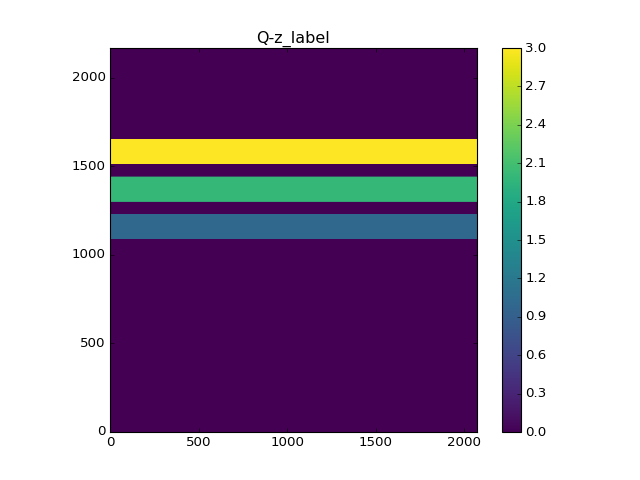

In [114]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(label_array_qz, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-z_label')
plt.show()

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


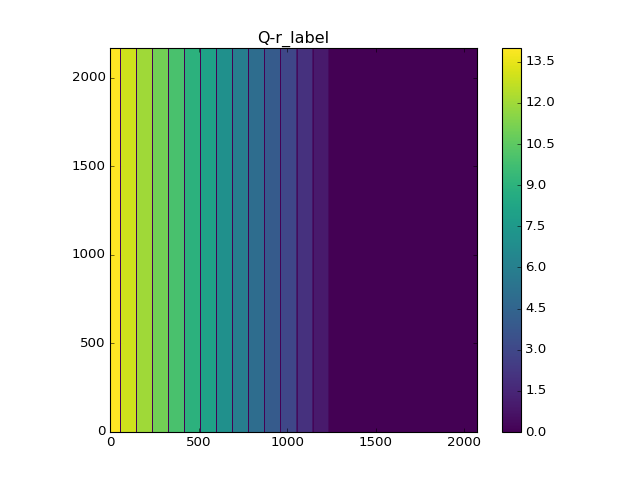

In [115]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(label_array_qr, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-r_label')
plt.show()

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


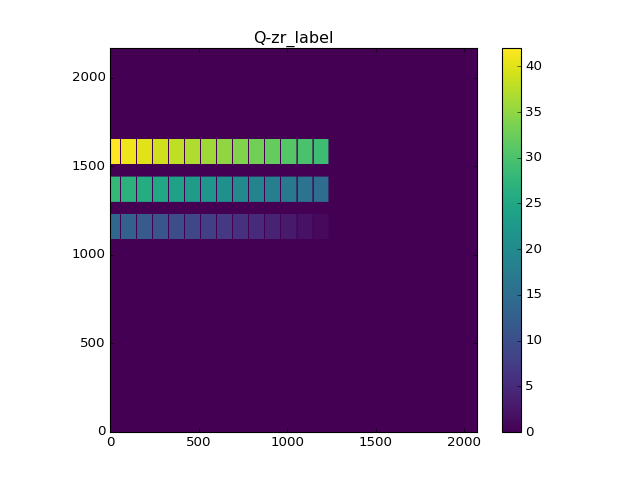

In [117]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(label_array_qzr, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-zr_label')
plt.show()

In [118]:
rings = label_array_qzr 
ring_mask = rings*mask
labels, indices = roi.extract_label_indices(ring_mask)

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


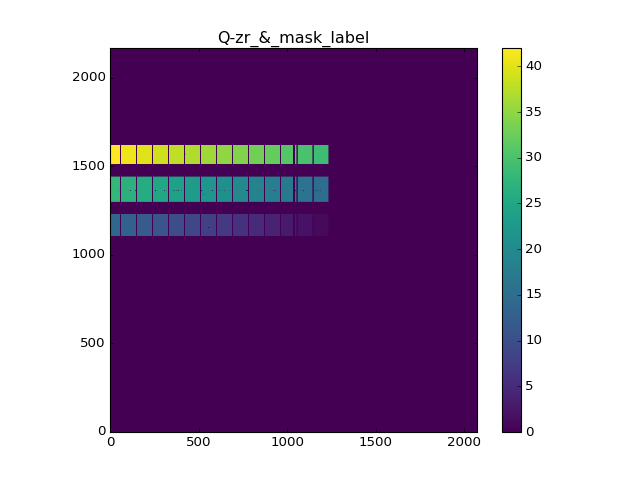

In [119]:
fig, ax = plt.subplots()
#im=ax.imshow(alphaf, origin='lower' ,cmap='viridis',norm= LogNorm(vmin=0.0001,vmax=2.00))
im=ax.imshow(ring_mask, origin='lower' ,cmap='viridis',vmin=0,vmax= None )
fig.colorbar(im)
ax.set_title( 'Q-zr_&_mask_label')
plt.show()

## Number of pixels in each q ring

In [120]:
ring_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [121]:
nopr = np.bincount( np.array(labels, dtype=int) )[1:]
nopr

array([10500, 10500,  9374, 10500, 10625, 10500, 10625, 10483, 10500,
       10625, 10500, 10625, 10500,  6750, 11814, 11829, 10517, 11814,
       11971, 11812, 11957, 11811, 11829, 11953, 11812, 11967, 11814,
        7602,  9072,  9072,  8100,  9072,  9170,  9072,  9179,  9072,
        9065,  9177,  9072,  9180,  9072,  5831])

# check one_qz_qr_region

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


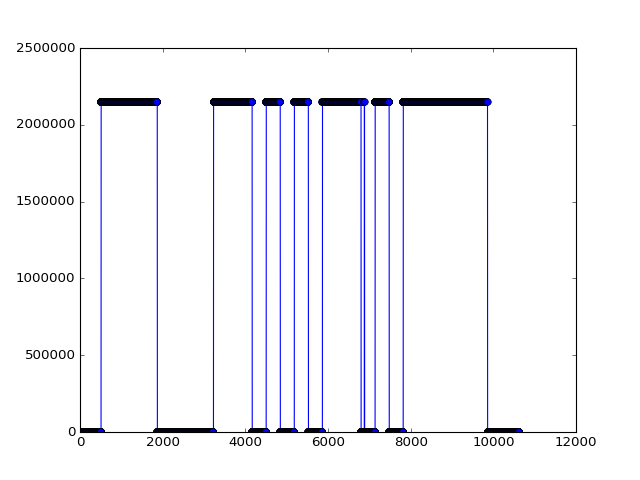

In [122]:
pixel = roi.roi_pixel_values(avg_img*mask, ring_mask, [10] )
fig,ax=plt.subplots()
ax.plot( pixel[0][0] ,'bo', ls='-' )


In [123]:
class Masker(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask
masker = Masker(imgs, mask)    

In [124]:
masker = Masker(imgs, mask)

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


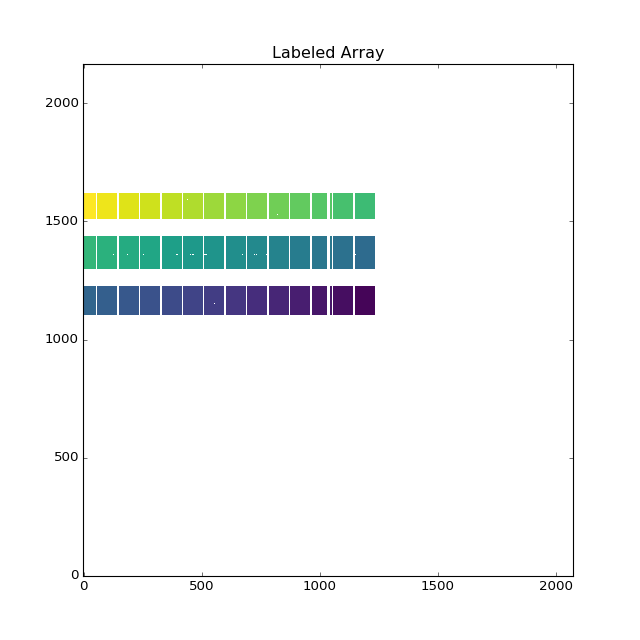

In [125]:
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis',origin='lower')

rwidth = 200 

#x1,x2 = [center[1] - rwidth, center[1] + rwidth]
#y1,y2 = [center[0] - rwidth, center[0] + rwidth]
#axes.set_xlim( [x1,x2])
#axes.set_ylim( [y1,y2])


In [126]:
def show_label_array_on_image(ax, image, label_array, cmap=None,
                              imshow_cmap='gray', norm=LogNorm(), **kwargs):
    """
    This will plot the required ROI's(labeled array) on the image
    Additional kwargs are passed through to `ax.imshow`.
    If `vmin` is in kwargs, it is clipped to minimum of 0.5.
    Parameters
    ----------
    ax : Axes
        The `Axes` object to add the artist too
    image : array
        The image array
    label_array : array
        Expected to be an unsigned integer array.  0 is background,
        positive integers label region of interest
    cmap : str or colormap, optional
        Color map to use for plotting the label_array, defaults to 'None'
    imshow_cmap : str or colormap, optional
        Color map to use for plotting the image, defaults to 'gray'
    norm : str, optional
        Normalize scale data, defaults to 'Lognorm()'
    Returns
    -------
    im : AxesImage
        The artist added to the axes
    im_label : AxesImage
        The artist added to the axes
    """
    ax.set_aspect('equal')
    im = ax.imshow(image, cmap=imshow_cmap, interpolation='none', norm=norm,
                   **kwargs)
    im_label = mpl_plot.show_label_array(ax, label_array, cmap=cmap, norm=norm,
                                **kwargs)
    return im, im_label

In [127]:

# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array on Averaged Data")
im = show_label_array_on_image(axes, avg_img2, ring_mask, imshow_cmap='viridis', cmap='Paired',
                        norm= LogNorm( vmin=0.001, vmax=1e2 ) ,  origin="lower")
#rwidth = 200 
#x1,x2 = [center[1] - rwidth, center[1] + rwidth]
#y1,y2 = [center[0] - rwidth, center[0] + rwidth]
#axes.set_xlim( [x1,x2])
#axes.set_ylim( [y1,y2])

plt.show()

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

NameError: name 'avg_img2' is not defined

##  Kymograph(waterfall plot) of the 3rd ring

In [ ]:
kymo = roi.kymograph(imgsr[::50], ring_mask, num = 1)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(kymo.T, cmap='viridis', vmax=10)
#fig.colorbar( im   )
ax.set_aspect(0.002)
plt.show()

##  Mean intensities for each interested qz_qr

In [ ]:
mask_data = masker[::50]  #this one is too slow if make  masker[::1]
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

In [ ]:
mean_int_sets.shape

In [ ]:
time = np.arange(len(mask_data))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each Qzr")
for i in range(num_qzr):
    ax.plot(time, mean_int_sets[:,i], label="Qzr "+str(i+1))
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [ ]:
#ring_mask = np.array( ring_mask, dtype=int)

In [ ]:
num_lev = 9  
num_buf = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf,  ring_mask, imgsr)

In [ ]:
num_qr, num_qz, num_qzr

In [ ]:
g2.shape

### Plot the one time correlation functions

In [ ]:
lags = lag_steps*timeperframe
for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10, 8))
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_title(" Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$')
        y=g2[:, sn + qz_ind * num_qr]
        ax.semilogx(lags, y, '-o', markersize=6) 
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
    plt.show()
    fig.tight_layout()  





    

# Fit g2

In [ ]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)


In [ ]:
rate = []

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid, fontsize=20, y =1.02)  
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 )
    y=g2[1:, sn]
    result1 = mod.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, baseline=1.0)
    rate.append(result1.best_values['relaxation_rate'])
    
    ax.semilogx(lags[1:], y, 'ro')
    ax.semilogx(lags[1:], result1.best_fit, '-b')
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.3f$'%(rate[sn]) +  r'$ s^{-1}$'
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes)              
 
fig.tight_layout()  

In [ ]:
result1.best_values

## Plot the relaxation rates vs (q_ring_center)**2

In [ ]:
fig, ax=plt.subplots()
ax.plot(q_ring_center**2, rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

# Fitted the Diffusion Coefficinet D0

In [ ]:
D0 = np.polyfit(q_ring_center**2, rate, 1)
gmfit = np.poly1d(D0)
print ('The fitted diffusion coefficient D0 is:  %.2E   A^2S-1'%D0[0])

In [ ]:
fig,ax = plt.subplots()
ax.plot(q_ring_center**2, rate, 'ro', ls='--')
ax.plot(q_ring_center**2,  gmfit(q_ring_center**2),  ls='-')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()